# CNN in Python
在此我們要示範如何使用Python進行類神經網路CNN的實作


## Data Prepared

本次將使用Cat & Dog classification資料集


In [2]:
# import tensorflow as tf
import numpy as np
# # 將資料及下載至雲端的暫存記憶體當中
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O /tmp/cats_and_dogs_filtered.zip

# Zip

In [2]:
# import os
# import zipfile

# # 資料解壓縮
# local_zip = '/Users/shawn/Desktop/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/Users/shawn/Desktop/cats_and_dogs_filtered')
# zip_ref.close()

In [5]:
# 修改圖片大小方便模型訓練
# 讀取dataset
image_size = (224, 224)

# train_dir = "/Users/shawn/Desktop/cats_and_dogs_filtered/train"
# val_dir = "/Users/shawn/Desktop/cats_and_dogs_filtered/validation"

train_dir = r"C:\Users\n9613\OneDrive\Desktop\cats_and_dogs_filtered\train"
val_dir = r"C:\Users\n9613\OneDrive\Desktop\cats_and_dogs_filtered\validation"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=1337,
    image_size=image_size,
    label_mode="binary",
    batch_size=20
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=1337,
    image_size=image_size,
    label_mode="binary",
    batch_size=20
)

# 對資料進行標準化，使得圖片的像素值介於0~1之間
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
0.0010948742 1.0


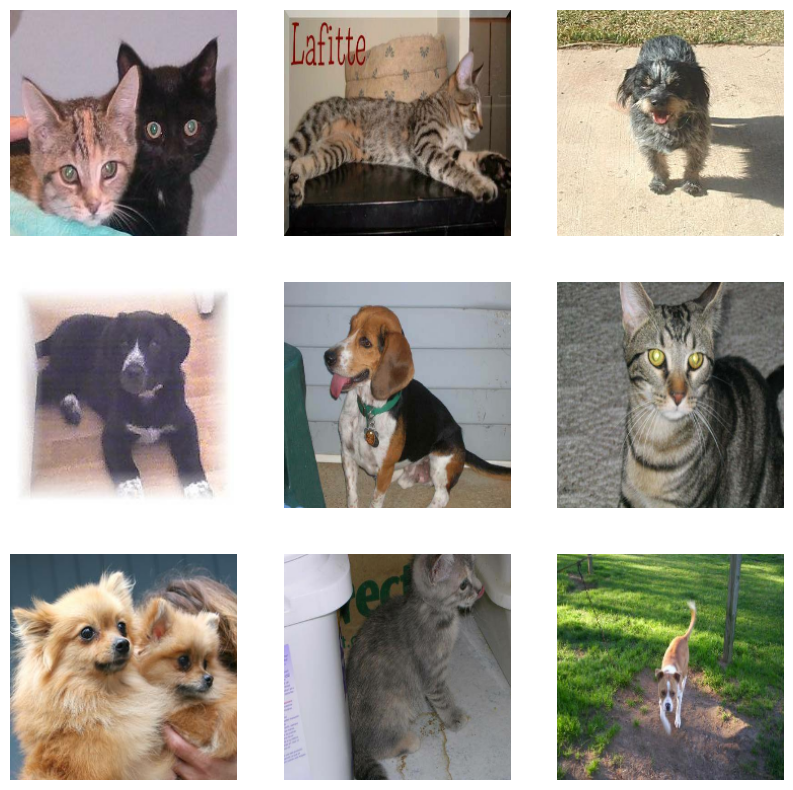

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.axis("off")

## Data Preprocessing

### Data Generator
因為本資料集內的訓練資料只有2000筆，數量過少因此需要再多加上資料增生的步驟

In [7]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# 每次讀取一張圖片時，會對圖片進行隨機的縮放及旋轉
# 因此對電腦來說每次讀取的都是不一樣的圖片
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [11]:
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


## Model Training

資料準備完成後，開始設定CNN模型架構

In [12]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input

### setting model architecture
1. `out = Conv2D(A, (B, C), activation='relu', padding='same')(in)`

  *   in: input of Conv2D
  *   out: output of Conv2D
  *   A: Number of kernel
  *   (B, C): Size of kernel
  *   activation: 'relu' / 'sigmoid' / 'softmax' / ...
  *   padding: "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input.

2.   `out = MAXPooling2D((A, B), strides=(C, D))(in)`
  *   (A, B): pool size
  *   strides: Specifies how far the pooling windows moves for each pooling step. If None, it will default to pool_size.

3.   `out = Flatten()(in)`
  *   Flattens the input. Does not affect the batch size.
  *   example: `[[1, 2], [3, 4]]` => `[1, 2, 3, 4]`

4.   `out = Dense(A, activation='relu')(in)`
  *   Fully connected Layer
  *   A: dimensionality of the output space

In [13]:
def myModel1():
  input_tensor=Input(shape=(224,224,3))

  # 卷積層1
  x = Conv2D(4, (3, 3), activation='relu', padding='same')(input_tensor)
  # 采樣層1
  x = MaxPooling2D((4, 4), strides=(4, 4))(x)

  # 卷積層2
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # 采樣層2
  x = MaxPooling2D((3, 3), strides=(3, 3))(x)

  # 卷積層3
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  # 采樣層3
  x = MaxPooling2D((3, 3), strides=(3, 3))(x)

  x = Flatten()(x)

  # 全連接層
  x = Dense(6, activation='relu')(x)

  # 輸出層 => 因為結果只有兩種，不是貓就是狗，因此不是1就是0
  output_tensor = Dense(1, activation='sigmoid')(x)
  model = Model(input_tensor, output_tensor)

  return model

In [14]:
from keras.applications.vgg16 import VGG16

def myModel2():
  # load model
  # include_top:VGG16預設的全連接層使用與否
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
  class2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(class1)
  class3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(class2)
  output = Dense(1, activation='sigmoid')(class3)

  # define new model
  model = Model(inputs=model.inputs, outputs=output)

  return model

### model summary
可看到剛剛設定好的模型架構

In [15]:
# 原始數據
model = myModel1()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         3,462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,045 (19.71 KB)

 Trainable params: 5,045 (19.71 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 生成數據模型
model_gen = myModel1()
model_gen.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 18, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,045 (19.71 KB)

 Trainable params: 5,045 (19.71 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 使用VGG16 model
# 原始數據
model_VGG = myModel2()
model_VGG.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,724,609 (105.76 MB)

 Trainable params: 13,009,921 (49.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Setting optimizer and loss function


In [18]:
# 透過優化器改善模型效能 => 最小化損失函數
# 讓模型訓練的過程盡可能使用更少的時間，以及更少的迭代次數
# learning_rate: 參數修改的幅度大小
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
momentum = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# 使用生成數據
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
momentum = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model_gen.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# 使用VGG16 模型
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
momentum = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model_VGG.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

### Train
*   epoch: Number of epochs to train the model
*   verbos: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.



In [21]:
# 使用原始數據
## acc = 0.96
hist = model.fit(
   train_ds,
   epochs=40,
   validation_data=val_ds,
   verbose=1
)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5035 - loss: 0.6914 - val_accuracy: 0.6240 - val_loss: 0.6770
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5950 - loss: 0.6698 - val_accuracy: 0.6670 - val_loss: 0.6338
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6333 - loss: 0.6348 - val_accuracy: 0.6670 - val_loss: 0.6191
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6711 - loss: 0.6083 - val_accuracy: 0.6890 - val_loss: 0.6017
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6903 - loss: 0.5896 - val_accuracy: 0.7230 - val_loss: 0.5794
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7060 - loss: 0.5671 - val_accuracy: 0.6810 - val_loss: 0.5981
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7280 - loss: 0.5451 - val_accuracy: 0.7170 - val_loss: 0.5667
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7446 - loss: 0.5224 - val_accu

In [22]:
# 使用生成數據
hist_gen = model_gen.fit(
   train_generator,
   epochs=40,
   validation_data=validation_generator,
   verbose=1
)

c:\Users\n9613\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4931 - loss: 0.6933

c:\Users\n9613\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.4932 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.5118 - loss: 0.6914 - val_accuracy: 0.5020 - val_loss: 0.6931
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.4989 - loss: 0.6930 - val_accuracy: 0.5950 - val_loss: 0.6880
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.5466 - loss: 0.6900 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.5055 - loss: 0.6931 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.5110 - loss: 0.6930 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.4732 - loss: 0.6935 - val_accuracy: 0.5020 - val_loss: 0.6931
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.4887 - loss: 0.6933 - val_accuracy: 0.500

In [23]:
# 使用VGG16模型
hist_VGG = model_VGG.fit(
   train_generator,
   epochs=40,
   validation_data=validation_generator,
   verbose=1
)

Epoch 1/40


c:\Users\n9613\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6390 - loss: 0.6498 - val_accuracy: 0.8860 - val_loss: 0.2954
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8123 - loss: 0.3984 - val_accuracy: 0.8890 - val_loss: 0.2607
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8400 - loss: 0.3649 - val_accuracy: 0.9130 - val_loss: 0.2128
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8746 - loss: 0.2909 - val_accuracy: 0.9110 - val_loss: 0.2237
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8867 - loss: 0.2673 - val_accuracy: 0.9240 - val_loss: 0.1969
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8686 - loss: 0.2785 - val_accuracy: 0.9180 - val_loss: 0.2101
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8860 - loss: 0.2621 - val_accuracy: 0.9280 - val_loss: 0.1860
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8887 - loss: 0.2460 - val_accuracy: 0.9240 - val_loss: 0.

### Save Model

In [24]:
model.save("myModel.h5")
new_model = tf.keras.models.load_model('myModel.h5')
val_loss, val_acc = new_model.evaluate(val_ds, verbose=1)
print("val_loss=", val_loss)
print("val_acc=", val_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7252 - loss: 0.6601
val_loss= 0.6273895502090454
val_acc= 0.7319999933242798


## Evaluation
用視覺化圖表呈現並評估模型分類結果
可從下列圖表觀察到：
1.   使用原始數據的訓練的模型：
  *   可發現在第10次過後，validation accuracy 曲線幾乎持平不再有所增長
  *   反之，train accuracy 仍持續飆高，因此推測此為模型 overfitting 的結果
  *   原因可能為：訓練數據樣本太少、learning rate 太高、訓練次數太多...


2.   使用生成數據的訓練的模型
  *   模型最終準確度落在 70% 左右
  *   train / val 的準確度差不多，模型沒有overfitting

3.   使用 VGG16 模型
  *   不同於前兩者，VGG16從訓練之初就展現出良好的準確度
  *   模型最終準確度落在 91% 左右
  *   train / val 的準確度差不多，因此模型沒有overfitting

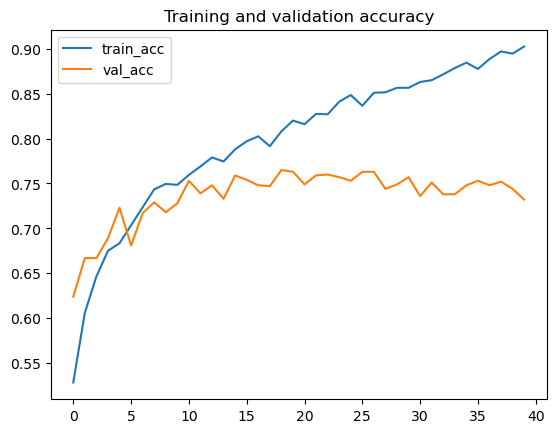

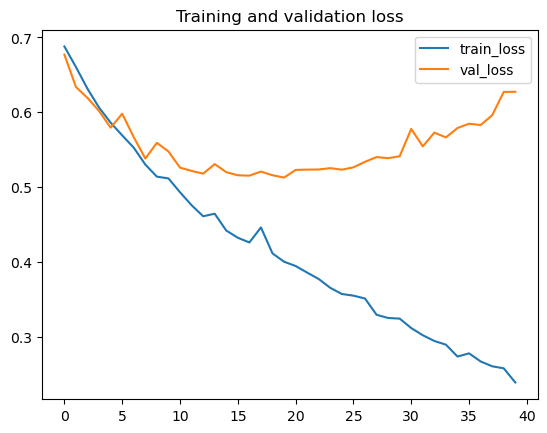

In [25]:
import matplotlib.pyplot as plt

# 使用原始數據
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="train_acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title('Training and validation loss')
plt.legend()

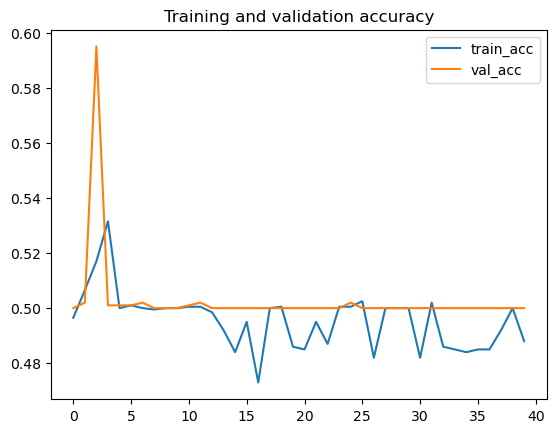

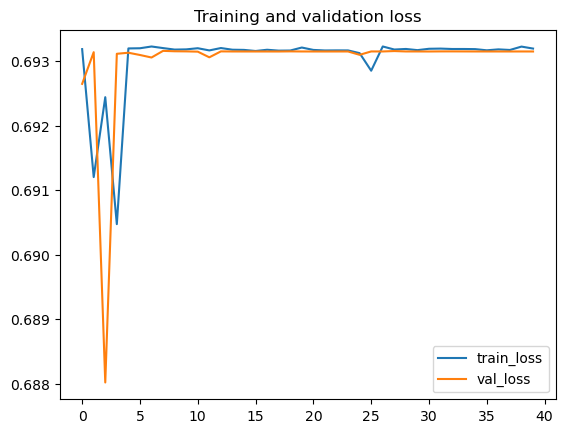

In [26]:
# 使用生成數據
acc = hist_gen.history['accuracy']
val_acc = hist_gen.history['val_accuracy']

loss = hist_gen.history['loss']
val_loss = hist_gen.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="train_acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title('Training and validation loss')
plt.legend()

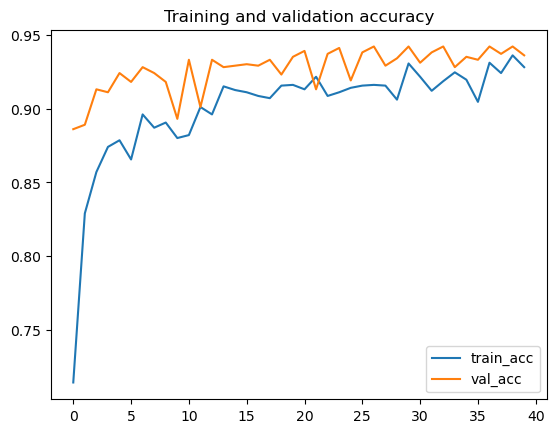

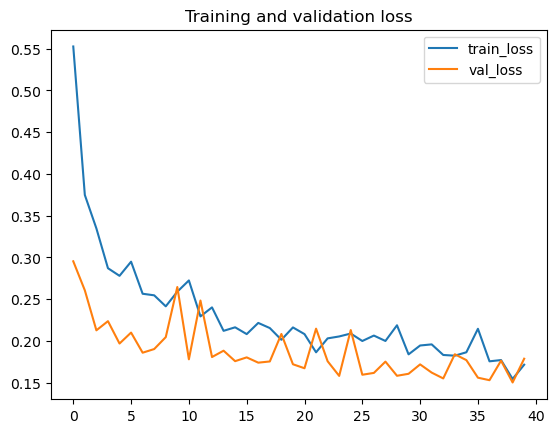

In [27]:
# 使用VGG16模型
acc = hist_VGG.history['accuracy']
val_acc = hist_VGG.history['val_accuracy']

loss = hist_VGG.history['loss']
val_loss = hist_VGG.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="train_acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title('Training and validation loss')
plt.legend()

### Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
It is a cat.
Result = 0.076125
Test time : 0.074254 second


C:\Users\n9613\AppData\Local\Temp\ipykernel_8876\2230053303.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Result = %f" %result)


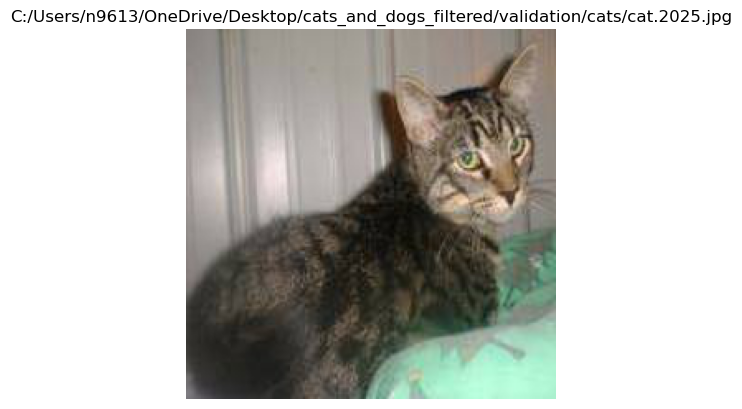

In [34]:
from PIL import Image

animal = "cat" # cat or dog
index = 2025 # 2000-2499
img_path = f"C:/Users/n9613/OneDrive/Desktop/cats_and_dogs_filtered/validation/{animal}s/{animal}.{index}.jpg"
img = Image.open(img_path).resize((224, 224)) # this is a PIL image

plt.title(img_path)
plt.axis("off")
plt.imshow(img)

x = np.asarray(img) # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 224, 224, 3)
x = x/255 # Rescale by 1/255

import time

start = time.time() # record start time

result = new_model.predict(x) # inferece(predict)

if result < 0.5:
    print("It is a cat.")
else:
    print("It is a dog.")

finish = time.time()
print("Result = %f" %result)
print("Test time : %f second" %(finish-start))